## 准备工作
### 创建图像数据、标注数据的文件路径列表

In [18]:
# 包装的import
import os.path as osp
import numpy as np
import cv2
import random

#从文件和文本中读取、加工、保存XML的库
import xml.etree.ElementTree as ET

import torch
import torch.utils.data as data

import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
# 设定随机数的种子，
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [20]:
#创建学习、验证用图像数据和标注数据的文件路径列表

def make_datapath_list(rootpath):
    #rootpath:数据文件夹路径

    #创建图像文件和标注文件的路径模板
    imgpath_template = osp.join(rootpath,'JPEGImages','%s.jpg')
    annopath_template = osp.join(rootpath,'Annotations','%s.xml')

    #分别取得训练和验证用的文件的ID
    train_id_names = osp.join(rootpath+'ImageSets/Main/train.txt')
    val_id_names = osp.join(rootpath+'ImageSets/Main/val.txt')

    #创建训练数据的图像数据和标注文件的路径列表
    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip()                     #删除空格和换行符
        # print(file_id)
        img_path = (imgpath_template % file_id)    #图像的路径
        anno_path = (annopath_template % file_id)  #标注的路径
        train_img_list.append(img_path)            #添加到列表中
        train_anno_list.append(anno_path)          #添加到列表中

    #创建验证数据的图像数据和标注文件的路径列表
    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()                     #删除空格和换行符
        # print(file_id)
        img_path = (imgpath_template % file_id)    #图像的路径
        anno_path = (annopath_template % file_id)  #标注的路径
        val_img_list.append(img_path)              #添加到列表中
        val_anno_list.append(anno_path)            #添加到列表中
    
    return train_img_list,train_anno_list,val_img_list,val_anno_list


In [21]:
rootpath = './data/VOCdevkit/VOC2012/'
train_img_list,train_anno_list,val_img_list,val_anno_list = make_datapath_list(rootpath)

print(train_img_list[0])
print(train_anno_list[0])

./data/VOCdevkit/VOC2012/JPEGImages\2008_000008.jpg
./data/VOCdevkit/VOC2012/Annotations\2008_000008.xml


### 将xml的标注数据转换成列表

In [22]:
# 将xml格式的标注转换成列表形式的类

class Anno_xml2list(object):
    def __init__(self,classes):
        self.classes = classes 
    
    def __call__(self,xml_path,width,height):
        """
        使用图像的尺寸信息，对每一张包含xml格式的标注数据进行正规化处理，并保存到列表中

        ret: [[xmin,ymin,xmax,ymax,label_ind],...]
        """

        #将图像包含的所有标注数据保存到列表中
        ret = []

        #读取xml文件
        xml = ET.parse(xml_path).getroot()

        #将图像内包含的物体数量作为循环次数进行迭代
        for obj in xml.iter('object'):

            #将标注中注明检测难度为difficult的对象剔除
            difficult = int(obj.find('difficult').text)
            if difficult == 1:
                # print(difficult)
                continue

            #用于保存每个物体的标注信息列表
            bndbox = []
            name = obj.find('name').text.lower().strip() #物体名称
            # print(name)
            bbox = obj.find('bndbox')
            
            #获取标注xmin、ymin、xmax、ymax,并归一化为0~1之间
            pts = ['xmin','ymin','xmax','ymax']
            for pt in pts:
                #VOC的原点是从（1，1）开始，减1变成（0，0）
                cur_pixl = int(bbox.find(pt).text) - 1

                #归一化
                if pt == 'xmin' or pt == 'xmax':
                    cur_pixl /= width
                else:
                    cur_pixl /= height
                bndbox.append(cur_pixl)
            #取得分类名的index并添加
            label_index = self.classes.index(name)
            bndbox.append(label_index)

            ret += [bndbox]

        return np.array(ret)


In [23]:
#确认
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']
transform_anno = Anno_xml2list(voc_classes)

# 使用OpenCV读取图像
ind = 1
image_file_path = val_img_list[ind]
img = cv2.imread(image_file_path)   #(333, 500, 3) (height,width,RGB)
height,width,channels = img.shape 

#以列表形式表示标注
transform_anno(val_anno_list[ind],width,height)

array([[ 0.09      ,  0.03003003,  0.998     ,  0.996997  , 18.        ],
       [ 0.122     ,  0.56756757,  0.164     ,  0.72672673, 14.        ]])

## 创建实现图像与标注的预处理DataTransform类

In [24]:
from utils.data_augumentation import Compose,ConvertFromInts,ToAbsoluteCoords,PhotometricDistort,Expand,RandomSampleCrop,RandomMirror,ToPercentCoords,Resize,SubtractMeans

In [25]:
class DataTransform():
    """
    图像和标注的预处理类。训练和推测时分别采用不同的处理
    将图像尺寸调整为 300 像素 ×300 像素
    学习时进行数据增强处理


    Attributes
    ----------
    input_size : int
        需要调整的图像大小。
    color_mean : (B, G, R)
        各个颜色通道的平均值。
    """

    def __init__(self, input_size, color_mean):
        self.data_transform = {
            'train': Compose([
                ConvertFromInts(),  #将int转换为float32
                ToAbsoluteCoords(),  #返回正规化后的标注数据
                PhotometricDistort(),  #随机地调整图像的色调
                Expand(color_mean),  #扩展图像的画布尺寸
                RandomSampleCrop(),  # 随机地截取图像内的部分内容
                RandomMirror(),  # 对图像进行翻转
                ToPercentCoords(),  # 将标注数据进行规范化，使其值在0~1的范围内
                Resize(input_size),  # 将图像尺寸调整为input_size×input_size
                SubtractMeans(color_mean) #将图像尺寸调整为input_size×input_size
            ]),
            'val': Compose([
                ConvertFromInts(),  #将int转换为float
                Resize(input_size),  #将图像尺寸调整为input_size×input_size
                SubtractMeans(color_mean)  #减去BGR的颜色平均值
            ])
        }

    def __call__(self, img, phase, boxes, labels):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            指定预处理的模式
        """
        return self.data_transform[phase](img, boxes, labels)

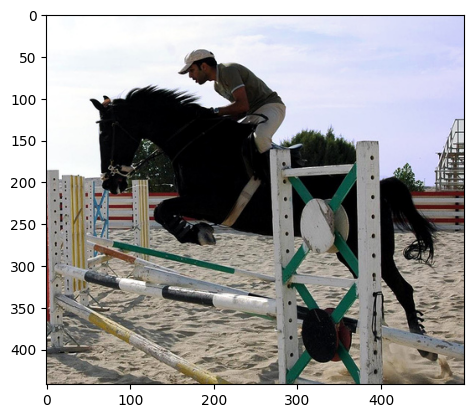

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


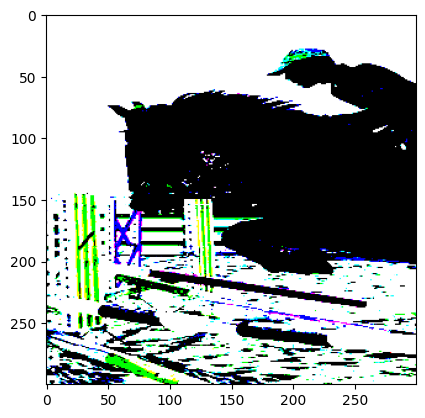

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


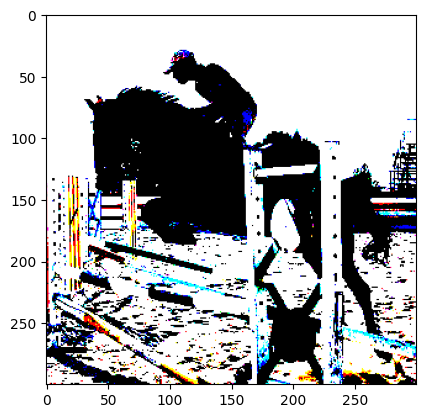

In [26]:
#确认执行结果

#1. 读取图像
image_file_path = train_img_list[0]
img = cv2.imread(image_file_path) #[高][宽0][RGB]
height,width,channels = img.shape 

#2. 将标注放入列表
transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(train_anno_list[0],width,height )

#3. 显示原图
plt.imshow(cv2.cvtColor(img,cv2.COLOR_RGB2BGR))
plt.show()

#4. 创建预处理类
color_mean = (104,117,123)
input_size = 300
transform = DataTransform(input_size,color_mean)

#5. 显示train的图像
phase = 'train' 
img_transformed, boxes, labels = transform(
    img,phase,anno_list[:,:4],anno_list[:,4])
plt.imshow(cv2.cvtColor(img_transformed,cv2.COLOR_BGR2RGB))
plt.show()

#6. 显示val的图像
phase = 'val' 
img_transformed, boxes, labels = transform(
    img,phase,anno_list[:,:4],anno_list[:,4])
plt.imshow(cv2.cvtColor(img_transformed,cv2.COLOR_BGR2RGB))
plt.show()

# 创建dataset

In [27]:
class VOCDataset(data.Dataset):
    """
    创建VOC2012的Dataset的类，继承自PyTorch的Dataset类

    Attributes
    ----------
    img_list : 列表
        保存图像路径的列表
    anno_list : リスト
       保存标注数据路径的列表
    phase : 'train' or 'test'
        用于指定是进行学习还是训练
    transform : object
       预处理类的实例
    transform_anno : object
        将xml格式的标注转换为列表的实例
    """
    def __init__(self, img_list, anno_list, phase, transform, transform_anno):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase  #指定train或val
        self.transform = transform  #图像的变形处理
        self.transform_anno = transform_anno  #将xml的标注转换为列表
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, index):
        #获取经过预处理的图像的张量形式和数据标注
        im, gt, h, w = self.pull_item(index)
        return im,gt
    
    def pull_item(self,index):
        #经过预处理的图像的张量格式的数据、标注数据，获取图像的高度和宽度
        
        # 1.读入图像
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)  #[ 高度 ][ 宽度 ][ 颜色BGR]
        height, width, channels = img.shape  #获取图像的尺寸

        # 2.将xml格式的标注信息转换为列表
        anno_file_path = self.anno_list[index]
        anno_list = self.transform_anno(anno_file_path, width, height)

       # 3.实施预处理
        img, boxes, labels = self.transform(
            img, self.phase, anno_list[:, :4], anno_list[:, 4])
       
        #由于颜色通道的顺序是BGR，因此需要转换为RGB的顺序
        #然后将（高度、宽度、颜色通道）的顺序变为（颜色通道、高度、宽度）的顺序
        img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)

        #创建由BBox和标签组合而成的np.array，变量名gt是ground truth（答案）的简称
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))

        return img, gt, height, width

In [35]:
#确认执行结果
color_mean = (104, 117, 123)  #(BGR)颜色的平均值
input_size = 300  #将图像的input尺寸转换为300像素×300像素

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

#取出第一个数据
val_dataset.__getitem__(1)[1]


array([[ 0.09      ,  0.03003003,  0.998     ,  0.996997  , 18.        ],
       [ 0.122     ,  0.56756757,  0.164     ,  0.72672673, 14.        ]])

# DataLoader实现